Cosmo MCMC is landing on biased HOD + Cosmology. I'm gonna first look at the code to make preds, and compare to the emulator. 

In [40]:
from pearce.emulator import OriginalRecipe, ExtraCrispy, SpicyBuffalo
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [41]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [42]:
training_file = '/scratch/users/swmclau2/xi_zheng07_cosmo/PearceRedMagicXiCosmoFixedNd.hdf5'
test_file = '/scratch/users/swmclau2/xi_zheng07_cosmo_test/PearceRedMagicXiCosmoFixedNd_Test.hdf5'

#test_file = '/u/ki/swmclau2/des/xi_cosmo_tester/PearceRedMagicXiCosmoFixedNd_test.hdf5'
em_method = 'gp'
split_method = 'random'

In [43]:
a = 1.0
z = 1.0/a - 1.0

In [44]:
fixed_params = {'z':z, 'cosmo': 3}#, 'r':0.53882047}

In [45]:
np.random.seed(0)
emu = SpicyBuffalo(training_file, method = em_method, fixed_params=fixed_params,
                 custom_mean_function = None, downsample_factor = 0.1)

In [46]:
emu.get_param_names()

['logM0', 'sigma_logM', 'logM1', 'alpha']

In [47]:
params = {}
for pname in emu.get_param_names():
    if pname == 'r':
        continue
    low, high = emu.get_param_bounds(pname)
    params[pname] = np.random.uniform(low, high)
    
print params

{'logM0': 14.746440511781975, 'sigma_logM': 0.22879734159310489, 'alpha': 1.0179532731987588, 'logM1': 14.305526752143287}


In [48]:
fixed_params = {}#'f_c':1.0}#,'logM1': 13.8 }# 'z':0.0}

cosmo_params = {'simname':'trainingbox', 'boxno': 3, 'scale_factors':[1.0], 'system': 'sherlock'}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

In [50]:
cat.load(1.0, HOD='zheng07')

In [52]:
print len(cat.halocat.halo_table)

9802138


In [53]:
cat._get_cosmo_param_names_vals()[1]

array([  2.26759000e-02,   1.12306400e-01,  -7.43737900e-01,
         9.48081200e-01,   3.00090000e+00,   6.40418900e+01,
         3.55625000e+00])

In [54]:
test_point_idx = 1
test_point_dict = dict(zip(emu.get_param_names(), emu.x[0][test_point_idx]*emu._x_std[0]+emu._x_mean[0]))

In [55]:
#hod_param_names = ['logM0', 'sigma_logM', 'logM1', 'alpha']
emulation_point = [('logM0', 14.0), ('sigma_logM', 0.2),
                    ('alpha', 1.083),('logM1', 13.7)]#, ('logMmin', 12.233)]

#em_params = {key:test_point_dict[key] for key in hod_param_names}
#em_params = dict(zip(hod_param_names, x_point))
em_params = dict(emulation_point)
em_params.update(fixed_params)

In [56]:
from scipy.optimize import minimize_scalar
def add_logMmin(hod_params, cat, nd = 1e-4):
    """
    In the fixed number density case, find the logMmin value that will match the nd given hod_params
    :param: hod_params:
        The other parameters besides logMmin
    :param cat:
        the catalog in question
    :return:
        None. hod_params will have logMmin added to it.
    """
    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        calc_nd = cat.calc_analytic_nd(hod_params)
        #print logMmin, calc_nd
        return (calc_nd - nd)**2

    res = minimize_scalar(func, bounds = (12, 16), args = (hod_params,), options = {'maxiter':100}, method = 'Bounded' )
    # assuming this doens't fail
    hod_params['logMmin'] = res.x


In [57]:
add_logMmin(em_params, cat)

In [58]:
r_bins = np.logspace(-1.1, 1.6, 19)
rpoints = (r_bins[1:]+r_bins[:-1])/2.0

In [59]:
em_params['logMmin']

13.131151239475283

In [60]:
_xi_vals = []
for i in xrange(5):
    cat.populate(em_params, min_ptcl=100)
    _xi_vals.append(cat.calc_xi(r_bins))

In [61]:
xi_vals = np.log10(np.array(_xi_vals))
y_calc = xi_vals.mean(axis = 0) #take one example as our xi. could also use the mean, but lets not cheat.
cov = np.cov(xi_vals.T)#/np.sqrt(50)

In [62]:
print em_params

{'logMmin': 13.131151239475283, 'logM1': 13.7, 'logM0': 14.0, 'sigma_logM': 0.2, 'alpha': 1.083}


In [63]:
y_calc

array([ 3.92626086,  3.73985564,  3.5249781 ,  3.29457872,  3.06926599,
        2.82193749,  2.56659584,  2.3154648 ,  2.07138388,  1.75260142,
        1.33983489,  0.95076921,  0.67060484,  0.42741013,  0.18348624,
       -0.06706249, -0.34806673, -0.6442047 ])

In [64]:
y = np.array([_y[test_point_idx] for _y in emu.y])
print y
y+= emu.mean_function([_x[test_point_idx]] for _x in emu.x)#[:,0]
print y

[ 4.30036305  4.08875128  3.86853856  3.64250733  3.40016038  3.15085267
  2.88788797  2.61272891  2.32651076  1.93707367  1.45509142  1.03125181
  0.75026646  0.5097665   0.26262001  0.00963081 -0.27590918 -0.57139177]
[ 4.30036305  4.08875128  3.86853856  3.64250733  3.40016038  3.15085267
  2.88788797  2.61272891  2.32651076  1.93707367  1.45509142  1.03125181
  0.75026646  0.5097665   0.26262001  0.00963081 -0.27590918 -0.57139177]


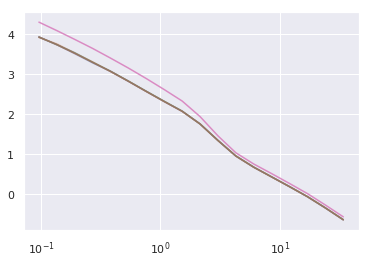

In [65]:
plt.plot(rpoints, xi_vals.T, alpha = 0.4)
plt.plot(rpoints, y_calc)
plt.plot(rpoints, y )

#plt.plot(rpoints, y_point-0.2)

plt.xscale('log')

In [66]:
# get cosmo params
del em_params['logMmin']
cpv = cat._get_cosmo_param_names_vals()

cosmo_param_dict = {key: val for key, val in zip(cpv[0], cpv[1])}

#em_params.update( cosmo_param_dict)


In [67]:
fixed_params = {'z':z, 'cosmo': 3}#, 'r':0.53882047}
train_x, train_y, _, _ = emu.get_data(training_file, fixed_params, None)

In [68]:
train_x

array([[ 14.40630631,   0.08903904,  13.30820821,   1.16996997,
         -1.01855591],
       [ 14.40630631,   0.08903904,  13.30820821,   1.16996997,
         -0.86855591],
       [ 14.40630631,   0.08903904,  13.30820821,   1.16996997,
         -0.71855592],
       ..., 
       [ 14.33423423,   0.12782783,  13.88878879,   0.82562563,
          1.23144409],
       [ 14.33423423,   0.12782783,  13.88878879,   0.82562563,
          1.38144409],
       [ 14.33423423,   0.12782783,  13.88878879,   0.82562563,
          1.53144409]])

{'logM1': 13.308208208208208, 'logMmin': 13.111142759638954, 'alpha': 1.1699699699699699, 'logM0': 14.406306306306307, 'sigma_logM': 0.089039039039039036}


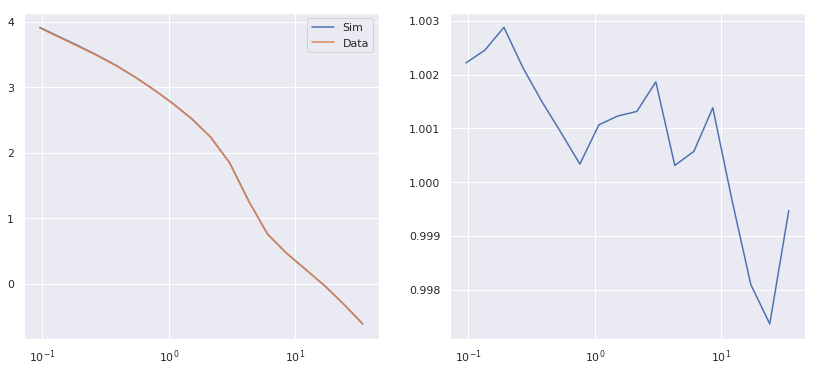

{'logM1': 13.53043043043043, 'logMmin': 13.1548738458964, 'alpha': 0.96616616616616624, 'logM0': 13.838738738738739, 'sigma_logM': 0.057507507507507508}


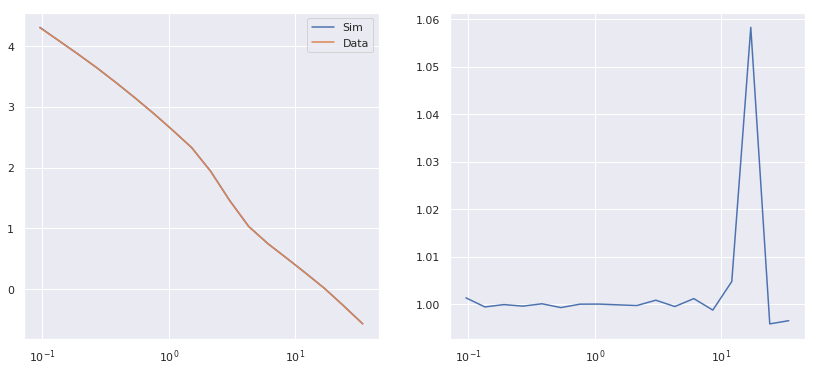

{'logM1': 13.57047047047047, 'logMmin': 13.289978349696289, 'alpha': 1.1503503503503503, 'logM0': 13.487387387387388, 'sigma_logM': 0.15885885885885886}


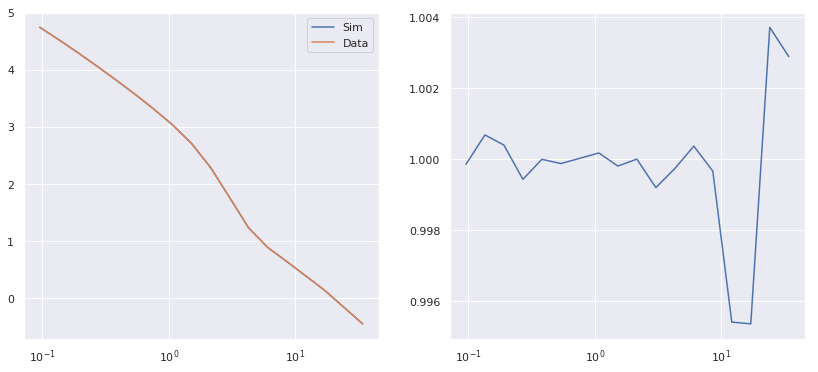

{'logM1': 13.636536536536536, 'logMmin': 13.129591367535564, 'alpha': 0.97577577577577579, 'logM0': 13.886786786786788, 'sigma_logM': 0.050000000000000003}


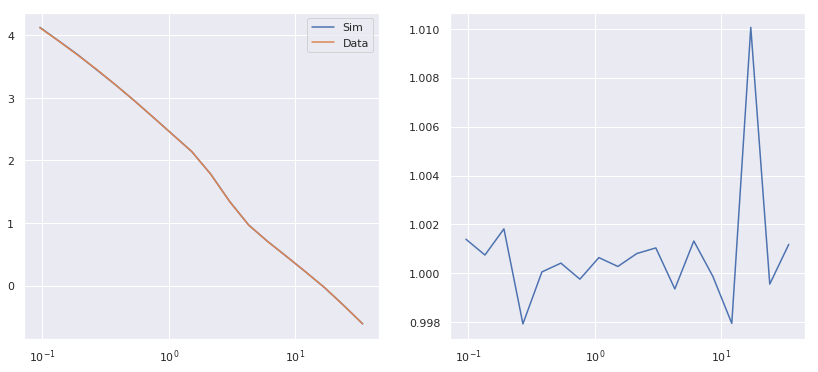

{'logM1': 14.169069069069069, 'logMmin': 13.087770372791431, 'alpha': 1.0986986986986986, 'logM0': 15.054954954954956, 'sigma_logM': 0.23418418418418419}


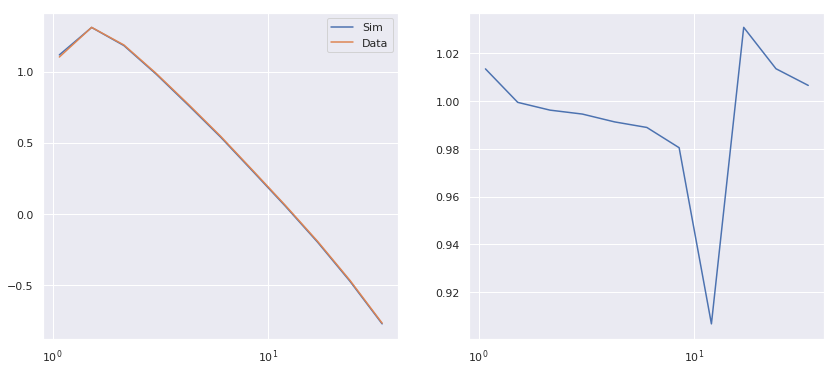

{'logM1': 14.485385385385385, 'logMmin': 13.087592383571755, 'alpha': 0.8264264264264265, 'logM0': 15.514414414414416, 'sigma_logM': 0.28773773773773775}


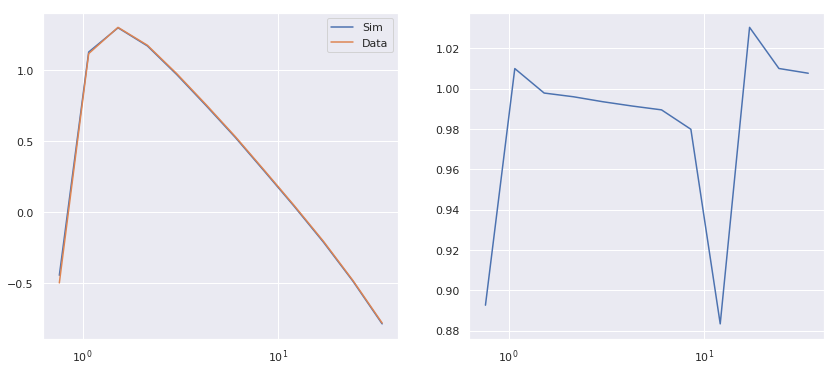

{'logM1': 14.359259259259259, 'logMmin': 13.086443017297935, 'alpha': 1.0290290290290289, 'logM0': 16.072972972972973, 'sigma_logM': 0.19639639639639639}


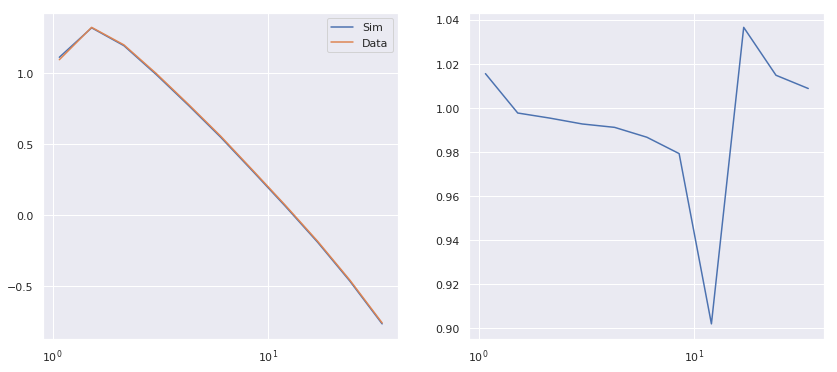

{'logM1': 13.354254254254254, 'logMmin': 13.076602508523697, 'alpha': 1.1663663663663664, 'logM0': 15.733633633633634, 'sigma_logM': 0.083283283283283285}


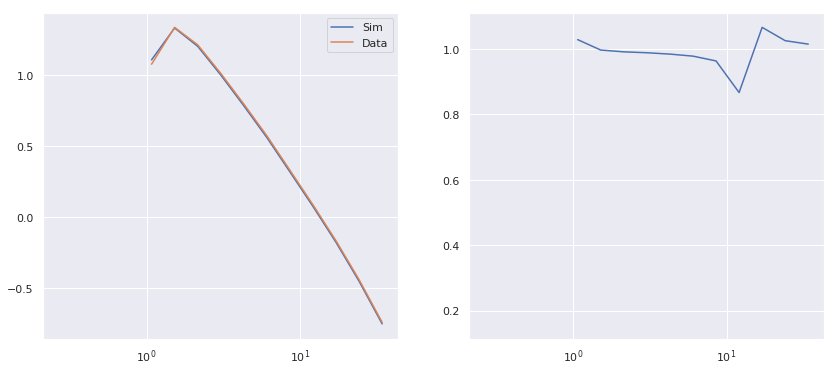

{'logM1': 13.528428428428429, 'logMmin': 13.348373931314516, 'alpha': 0.92932932932932932, 'logM0': 13.343243243243244, 'sigma_logM': 0.26271271271271274}


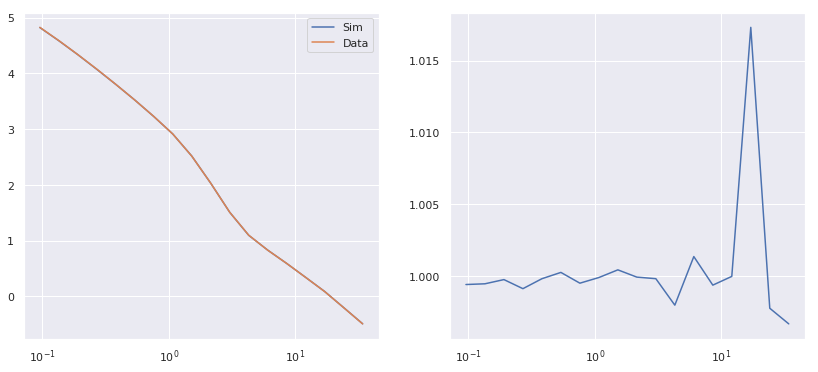

{'logM1': 13.692592592592593, 'logMmin': 13.097365969522574, 'alpha': 0.92852852852852852, 'logM0': 14.346246246246247, 'sigma_logM': 0.18763763763763763}


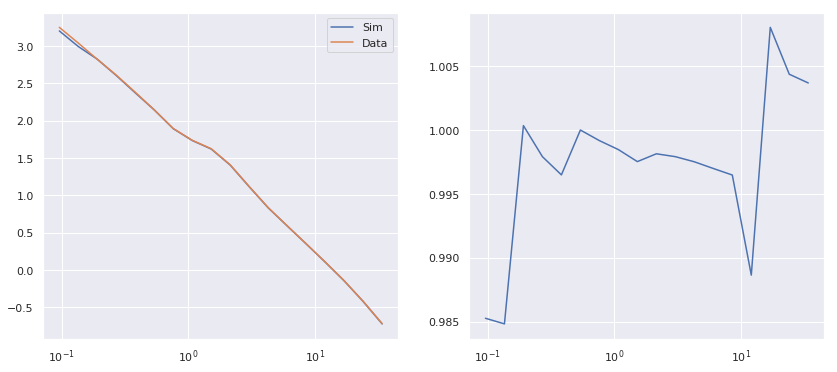

In [69]:
for idx in xrange(10):
    x_point = train_x[idx*emu.n_bins, :-1]
    y_point = train_y[idx*emu.n_bins:(idx+1)*emu.n_bins]
    pop_params = dict(zip(emu.get_param_names(), x_point))
    add_logMmin(pop_params, cat)
    print pop_params


    _xi_vals = []
    for i in xrange(10):
        cat.populate(pop_params, min_ptcl=100)
        _xi_vals.append(cat.calc_xi(r_bins))

    xi_vals = np.log10(np.array(_xi_vals))
    y_calc = xi_vals.mean(axis = 0)
    
    fig = plt.figure(figsize = (14, 6))

    plt.subplot(121)
    plt.plot(rpoints, y_calc, label = 'Sim')
    plt.plot(rpoints, y_point, label = 'Data')
    plt.xscale('log')
    plt.legend(loc = 'best')
    plt.subplot(122)
    plt.plot(rpoints, y_calc/y_point)
    plt.xscale('log')
    plt.show()